TOKENS -> PADDED -> EMBEDDING DIN TF   ann

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoscaMitrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
	if validation == True:
		val_to_plot = [model.history["val_"+el] for el in labels]
	to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [3]:
def label_distorsion_non_binary(row):  
    if row["Dominant Distortion"] == "All-or-nothing thinking":
        return 1
    if row["Dominant Distortion"] == "Overgeneralization":
        return 2
    if row["Dominant Distortion"] == "Mental filter":
        return 3
    if row["Dominant Distortion"] == "Should statements":
        return 4
    if row["Dominant Distortion"] == "Labeling":
        return 5
    if row["Dominant Distortion"] == "Personalization":
        return 6
    if row["Dominant Distortion"] == "Magnification":
        return 7
    if row["Dominant Distortion"] == "Emotional Reasoning":
        return 8
    if row["Dominant Distortion"] == "Mind Reading":
        return 9
    if row["Dominant Distortion"] == "Fortune-telling":
        return 10
    return 0

therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
data = pd.merge(therapis_responses,annotated_data,on='Id_Number').drop(["Question"], axis=1)
data["Distortion"] = data.apply(label_distorsion_non_binary, axis=1)
# 0 = ANSWER   ,   1 = ID   ,   2 = QUESTION   ,   3 = DISTORTED PART   ,
# 4 = DOMINANT DISTORTION   ,   5 = SECONDARY DISTORTION   ,   6 = DISTORTION 1/0

In [4]:
data["Distortion"].value_counts()

Distortion
0     933
9     239
2     239
7     195
5     165
6     153
10    143
8     134
3     122
4     107
1     100
Name: count, dtype: int64

In [5]:
value_to_drop = 0
column_to_check = 'Distortion'
number_to_drop = 650  # Number of rows to drop with the specified value

rows_with_value = data[data[column_to_check] == value_to_drop]

# Step 4: Randomly select a subset of these rows to drop
rows_to_drop = rows_with_value.sample(n=number_to_drop, random_state=42).index

# Step 5: Drop the selected subset from the DataFrame
data = data.drop(rows_to_drop)

In [6]:
data["Distortion"].value_counts()

Distortion
0     283
9     239
2     239
7     195
5     165
6     153
10    143
8     134
3     122
4     107
1     100
Name: count, dtype: int64

In [19]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

texts = data.values.tolist()

sentences = [el[2] for el in texts]
sentences = list(map(remove_stop_words,sentences))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [20]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_LEN = find_max_list(sequences)
#MAX_LEN =200

padded_sequences = pad_sequences(sequences,maxlen=MAX_LEN, padding='post')

#tokenizer.sequences_to_texts(padded_sequences)[:3]

In [24]:
distortions = [el[-1] for el in texts]
distortions = np.array(distortions)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, distortions)
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [26]:
model = Sequential() 
n_dim = 2
model.add(Embedding(VOCAB_LEN, n_dim, input_length=MAX_LEN))#Vocabulary size of Tokenizer / Number of dimensions in embedding space / Length of padded sequence
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 492, 2)            20942     
                                                                 
 flatten_1 (Flatten)         (None, 984)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                31520     
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 52,825
Trainable params: 52,825
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_train_onehot = tf.keras.utils.to_categorical(Y_train)
y_test_onehot = tf.keras.utils.to_categorical(Y_test)

In [29]:
hist = model.fit(X_train,y_train_onehot,validation_data=(X_test,y_test_onehot),epochs=10)

Epoch 1/10
45/45 [==============================] - 0s 11ms/step - loss: 1.2694 - accuracy: 0.9279 - precision: 0.9267 - recall: 0.2241 - val_loss: 2.4980 - val_accuracy: 0.9095 - val_precision: 0.5625 - val_recall: 0.0191
Epoch 2/10
45/45 [==============================] - 0s 10ms/step - loss: 1.1176 - accuracy: 0.9366 - precision: 0.9712 - recall: 0.3113 - val_loss: 2.5619 - val_accuracy: 0.9077 - val_precision: 0.3704 - val_recall: 0.0213
Epoch 3/10
45/45 [==============================] - 0s 10ms/step - loss: 0.9838 - accuracy: 0.9451 - precision: 0.9729 - recall: 0.4078 - val_loss: 2.6549 - val_accuracy: 0.9072 - val_precision: 0.3077 - val_recall: 0.0170
Epoch 4/10
45/45 [==============================] - 0s 10ms/step - loss: 0.8714 - accuracy: 0.9529 - precision: 0.9816 - recall: 0.4915 - val_loss: 2.7146 - val_accuracy: 0.9052 - val_precision: 0.3148 - val_recall: 0.0362
Epoch 5/10
45/45 [==============================] - 0s 11ms/step - loss: 0.7723 - accuracy: 0.9586 - precisi

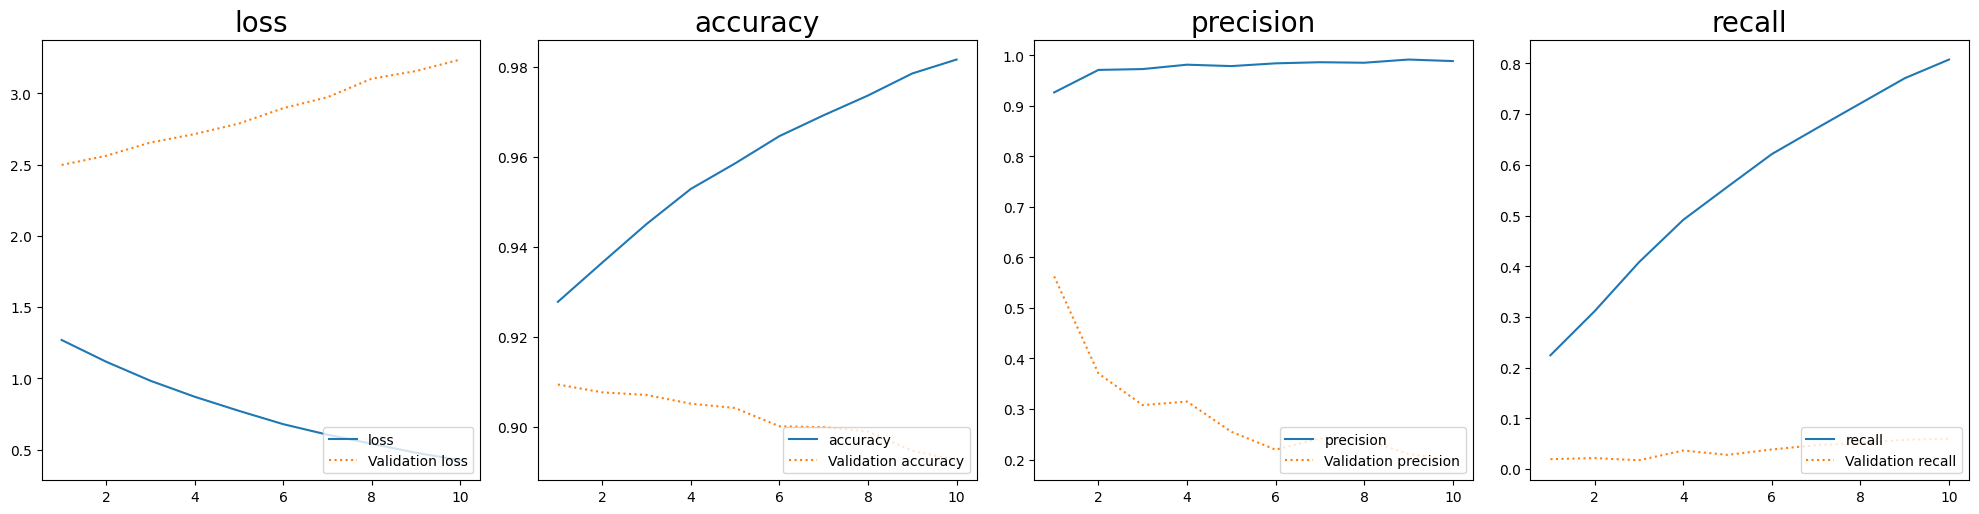

In [30]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],validation=True)

15/15 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'Truth')

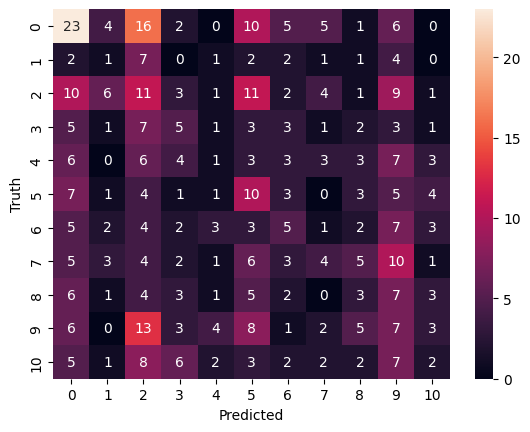

In [31]:
y_predicted = model.predict(X_test)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(Y_test, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')